In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height = 248, 248              #Image Width Height and Developement
batch_size = 30                               #Batch Size for Machine Learning Operations
image_input_shape = (img_height,img_width)    #Designated Tuple for the Image size

In [ ]:
train_data_dir = "/content/drive/MyDrive/Learning2Detect_train_data/train_cropped"
validation_data_dir = '/content/drive/MyDrive/Learning2Detect_train_data/test_cropped'

###########################################################################################
#
#When programming please make sure to modify your paths accordingly to the where the data is located in the Google Drive.
#
#
#
###########################################################################################

In [ ]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5
)
###############################################################
#
#
#Data augmentation processes were done here, and there were done using the ImageDataGenerator class from Keras
#
#
###############################################################

In [ ]:
test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5
)
###############################################################
#
#
#Data augmentation processes were done here, and there were done using the ImageDataGenerator class from Keras
#
#
###############################################################

In [ ]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = image_input_shape,
batch_size = batch_size,
class_mode = "categorical")
######################################################################
#
#
# The method for applying the Data Augmentation to all the files in a folder
# finally making 
#
######################################################################

Found 630 images belonging to 2 classes.


In [ ]:
#@title From the validation/testing directory perform Data Augmentation
validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = image_input_shape,
class_mode = "categorical")
######################################################################
#
#
# The method for applying the Data Augmentation to all the files in a folder
# finally making 
#
######################################################################

Found 300 images belonging to 2 classes.


In [ ]:
import sqlite3
blink = dict()
blink["Adamax"] = tf.optimizers.Adamax
blink["Adagrad"] = tf.optimizers.Adagrad
blink["Adadelta"] = tf.optimizers.Adadelta
blink["Adam"] = tf.optimizers.Adam
blink["Nadam"] = tf.optimizers.Nadam
blink["Ftrl"] = tf.optimizers.Ftrl
blink["RMSprop"] = tf.optimizers.RMSprop
blink["SGD"] = tf.optimizers.SGD

In [ ]:
blink_twice = dict()
blink_twice["VGG 16"] = tf.keras.applications.VGG16
blink_twice["VGG 19"] = tf.keras.applications.VGG19
blink_twice["MobileNetV2"] = tf.keras.applications.MobileNetV2
blink_twice["Xception"] = tf.keras.applications.Xception

In [ ]:
def otimhi(optim=None):
  return list(blink.keys())[list(blink.values()).index(optim)]
def otimhi1(app=None):
  return list(blink_twice.keys())[list(blink_twice.values()).index(app)]

In [ ]:
class ApplicationDevTF:
  def __init__(self,optimizer,loss,layers,application,learning_rate):
    self.optim = optimizer
    self.loss = loss
    self.layers = layers
    self.application =  application
    self.learning_rate = learning_rate
  def model_creation(self, input_shape, classes, weights="imagenet", include_top = False):
    base = self.application(
        input_shape = input_shape,
        classes = classes,
        weights = weights,
        include_top = include_top
    )
    x = base.output
    x = GlobalAveragePooling2D()(x)
    for i in self.layers:
      if not self.layers:
        break
      x = i(x)
    predictions = Dense(2, activation="sigmoid")(x)
    self.model = Model(base.input,predictions)

  def compile_model(self):
    self.model.compile(optimizer=self.optim(self.learning_rate),
              loss= self.loss,
              metrics=['accuracy'])
  def train_model(self, model_name, epochs, train_gen, validation_gen):
    self.model_name = model_name
    checkpoint = ModelCheckpoint(self.model_name, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    early_stopping = EarlyStopping(monitor= "val_accuracy", patience=5)
    history = self.model.fit(train_gen,
                              epochs=epochs,
                              validation_data=validation_gen,
                    callbacks = [checkpoint,early_stopping]
    )
    self.df_history = pd.DataFrame(history.history)

  def plotter(self, fig_name_loss, fig_name_acc):
    self.df_history[["loss","val_loss"]].plot()
    plt.grid(True)
    plt.show()
    plt.savefig(fig_name_loss)
    self.df_history[["accuracy","val_accuracy"]].plot()
    plt.grid(True)
    plt.show()
    plt.savefig(fig_name_acc)

  def row(self):
    a = self.df_history.iloc[self.df_history["val_accuracy"].idxmax()]
    self.loss_metric = a["loss"]
    self.val_loss_metric = a["val_loss"]
    self.acc = a["accuracy"]
    self.val_acc = a["val_accuracy"]

  def to_sql(self):
    
    con = sqlite3.connect("/content/drive/MyDrive/ITCZ_Research_end/ITCZ_Database.db")
    cur = con.cursor()
    cur.execute("INSERT OR REPLACE INTO ITCZ_512_RELU(Optimizer, Learning_Rate, Loss_Function, Model_name, Accuracy, Loss, Validation_Accuracy, Validation_Loss) VALUES (?,?,?,?,?,?,?,?) """,(otimhi(self.optim), self.learning_rate, self.loss,otimhi1(self.application),self.acc,self.loss_metric, self.val_acc, self.val_loss_metric))
    con.commit()
    con.close()

In [ ]:
for i in blink_twice.values():
  for j in ["binary_crossentropy","hinge"]:
    for k in blink.values():
      test1 = ApplicationDevTF(k,j,[Dense(512, activation="relu")],i,.001)
      test1.model_creation(input_shape=[248, 248,3],classes=2)
      test1.compile_model()
      test1.train_model("Dummy.h5",30,train_gen=train_generator,validation_gen=validation_generator)
      test1.row()
      test1.to_sql()

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 9.0672 - accuracy: 0.5159
Epoch 1: val_accuracy improved from -inf to 0.76667, saving model to Dummy.h5
21/21 [==============================] - 20s 889ms/step - loss: 9.0672 - accuracy: 0.5159 - val_loss: 0.6898 - val_accuracy: 0.7667
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5111
Epoch 2: val_accuracy did not improve from 0.76667
21/21 [==============================] - 17s 806ms/step - loss: 0.6937 - accuracy: 0.5111 - val_loss: 0.6801 - val_accuracy: 0.7500
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5238
Epoch 3: val_accuracy did not improve from 0.76667
21/21 [==============================] - 17s 802ms/step - loss: 0.6927 - accuracy: 0.5238 - val_loss: 0.6801 - val_accuracy: 0.7500
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5238
Epoch 4: val_accuracy did not improve from 0.766

In [ ]:
con = sqlite3.connect("/content/drive/MyDrive/ITCZ_Research_end/ITCZ_Database.db")
df = pd.read_sql("SELECT * FROM ITCZ_512_RELU ",con)
con.close()

In [ ]:
df

,Optimizer,Learning_Rate,Loss_Function,Size_of_Model,Accuracy,Loss,Validation_Loss,Validation_Accuracy,Model_name,ID_PROD
0,Adamax,0.001,binary_crossentropy,528.0,0.498413,1.940175,0.680094,0.750000,VGG 16,1.0
1,Adagrad,0.001,binary_crossentropy,528.0,0.601587,0.662740,0.639490,0.846667,VGG 16,2.0
2,Adadelta,0.001,binary_crossentropy,528.0,0.617460,0.660026,0.645022,0.870000,VGG 16,3.0
3,Adam,0.001,binary_crossentropy,528.0,0.498413,0.694256,0.667803,0.750000,VGG 16,4.0
4,Nadam,0.001,binary_crossentropy,528.0,0.520635,0.695336,0.629349,0.750000,VGG 16,5.0
...,...,...,...,...,...,...,...,...,...,...
60,Adam,0.001,hinge,88.0,0.568254,0.920019,0.771707,0.786667,Xception,NaN
61,Nadam,0.001,hinge,88.0,0.739683,0.759698,0.750000,0.750000,Xception,NaN
62,Ftrl,0.001,hinge,88.0,0.517460,0.999983,0.999952,0.750000,Xception,NaN
63,RMSprop,0.001,hinge,88.0,0.768254,0.731262,1.048455,0.456667,Xception,NaN


In [ ]:
#df.to_excel("ITCZ_512_RELU.xlsx")

In [ ]:
#!sqlite3 -header -csv "/content/drive/MyDrive/ITCZ_Research_end/ITCZ_Database.db" > "/content/drive/MyDrive/ITCZ_Research_end/"

In [ ]:
wf = df.iloc[:,:-1]

In [ ]:
wf

,Optimizer,Learning_Rate,Loss_Function,Size_of_Model,Accuracy,Loss,Validation_Loss,Validation_Accuracy,Model_name
0,Adamax,0.001,binary_crossentropy,528.0,0.498413,1.940175,0.680094,0.750000,VGG 16
1,Adagrad,0.001,binary_crossentropy,528.0,0.601587,0.662740,0.639490,0.846667,VGG 16
2,Adadelta,0.001,binary_crossentropy,528.0,0.617460,0.660026,0.645022,0.870000,VGG 16
3,Adam,0.001,binary_crossentropy,528.0,0.498413,0.694256,0.667803,0.750000,VGG 16
4,Nadam,0.001,binary_crossentropy,528.0,0.520635,0.695336,0.629349,0.750000,VGG 16
...,...,...,...,...,...,...,...,...,...
60,Adam,0.001,hinge,88.0,0.568254,0.920019,0.771707,0.786667,Xception
61,Nadam,0.001,hinge,88.0,0.739683,0.759698,0.750000,0.750000,Xception
62,Ftrl,0.001,hinge,88.0,0.517460,0.999983,0.999952,0.750000,Xception
63,RMSprop,0.001,hinge,88.0,0.768254,0.731262,1.048455,0.456667,Xception


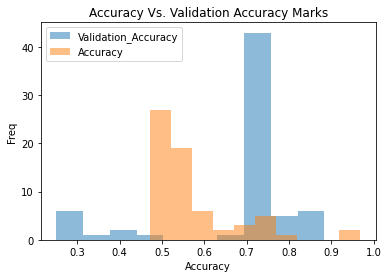

In [ ]:
fig, ax = plt.subplots()
ax.hist(wf['Validation_Accuracy'], alpha=.5)
ax.hist(wf['Accuracy'],alpha=.5)
ax.set_ylabel("Freq")
ax.set_xlabel("Accuracy")
ax.set_title("Accuracy Vs. Validation Accuracy Marks")
ax.legend(["Validation_Accuracy", "Accuracy"])
plt.show()
fig.savefig("Beta1.png")

In [ ]:
wf = wf.drop(columns='Learning_Rate') # Learning rate is constant 0.001
wf

,Optimizer,Loss_Function,Size_of_Model,Accuracy,Loss,Validation_Loss,Validation_Accuracy,Model_name
0,Adamax,binary_crossentropy,528.0,0.498413,1.940175,0.680094,0.750000,VGG 16
1,Adagrad,binary_crossentropy,528.0,0.601587,0.662740,0.639490,0.846667,VGG 16
2,Adadelta,binary_crossentropy,528.0,0.617460,0.660026,0.645022,0.870000,VGG 16
3,Adam,binary_crossentropy,528.0,0.498413,0.694256,0.667803,0.750000,VGG 16
4,Nadam,binary_crossentropy,528.0,0.520635,0.695336,0.629349,0.750000,VGG 16
...,...,...,...,...,...,...,...,...
60,Adam,hinge,88.0,0.568254,0.920019,0.771707,0.786667,Xception
61,Nadam,hinge,88.0,0.739683,0.759698,0.750000,0.750000,Xception
62,Ftrl,hinge,88.0,0.517460,0.999983,0.999952,0.750000,Xception
63,RMSprop,hinge,88.0,0.768254,0.731262,1.048455,0.456667,Xception


In [ ]:
wf['Loss_Function'] = wf['Loss_Function'].apply(lambda x: 1 if x == 'binary_crossentropy' else 0)

In [ ]:
wf[wf.isnull().any(axis=1)]

,Optimizer,Loss_Function,Size_of_Model,Accuracy,Loss,Validation_Loss,Validation_Accuracy,Model_name


In [ ]:
def func_replace_optim(a):
  if a  == "Adamax" : return 0
  elif a == "Adagrad": return 1
  elif a == "Adadelta": return 2
  elif a == "Adam": return 3
  elif a == "Nadam": return 4
  elif a == "Ftrl": return 5
  elif a == "RMSprop": return 6
  elif a == "SGD": return 7
  else: return -1

In [ ]:
wf['Optimizer'] = wf['Optimizer'].apply(func_replace_optim)
wf

,Optimizer,Loss_Function,Size_of_Model,Accuracy,Loss,Validation_Loss,Validation_Accuracy,Model_name
0,0,1,528.0,0.498413,1.940175,0.680094,0.750000,VGG 16
1,1,1,528.0,0.601587,0.662740,0.639490,0.846667,VGG 16
2,2,1,528.0,0.617460,0.660026,0.645022,0.870000,VGG 16
3,3,1,528.0,0.498413,0.694256,0.667803,0.750000,VGG 16
4,4,1,528.0,0.520635,0.695336,0.629349,0.750000,VGG 16
...,...,...,...,...,...,...,...,...
60,3,0,88.0,0.568254,0.920019,0.771707,0.786667,Xception
61,4,0,88.0,0.739683,0.759698,0.750000,0.750000,Xception
62,5,0,88.0,0.517460,0.999983,0.999952,0.750000,Xception
63,6,0,88.0,0.768254,0.731262,1.048455,0.456667,Xception


In [ ]:
def model_name_func(x):
  if x == "VGG 16": return 0
  elif x == "VGG 19": return 1
  elif x == "MobileNetV2": return 2
  elif x == "Xception": return 3
  else: return -1 
wf['Model_name'] = wf['Model_name'].apply(model_name_func)

Optimizer              0
Loss_Function          0
Size_of_Model          5
Accuracy               0
Loss                   0
Validation_Loss        0
Validation_Accuracy    0
Model_name             0
dtype: int64

In [ ]:
X, Y = wf.iloc[:,1:-1], wf.iloc[:,-1]

In [ ]:
X,Y = X.values.astype(float), Y.values.astype(float)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.33,random_state=1)

,Loss_Function,Size_of_Model,Accuracy,Loss,Validation_Loss,Validation_Accuracy
19,1,548.0,0.523810,7.451403e-01,0.603505,0.750000
33,1,14.0,0.757143,5.449874e-01,6.816632,0.250000
61,0,88.0,0.739683,7.596980e-01,0.750000,0.750000
17,1,548.0,0.515873,9.067247e+00,0.689759,0.766667
56,1,88.0,0.498413,6.945009e-01,0.654109,0.766667
54,1,88.0,0.514286,6.936729e-01,0.692978,0.750000
49,1,88.0,0.628571,6.267762e-01,0.863875,0.340000
34,1,14.0,0.519048,7.142690e-01,0.649760,0.740000
41,0,14.0,0.742857,7.700022e-01,1.245388,0.250000
52,1,88.0,0.498413,7.004524e-01,0.687309,0.750000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:551: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity=affinity
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:551: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity=affinity
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:281: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity="euclidean"
/usr/local/lib/python3.7/dist-packages/sklearn/

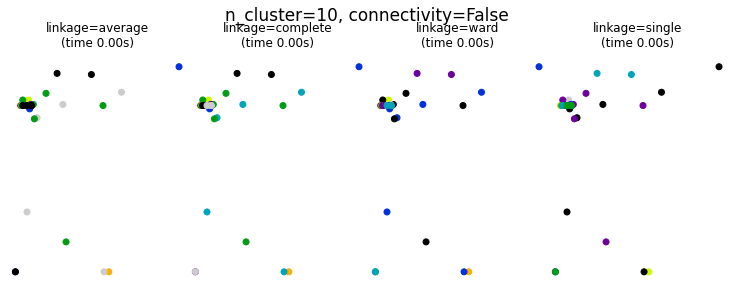

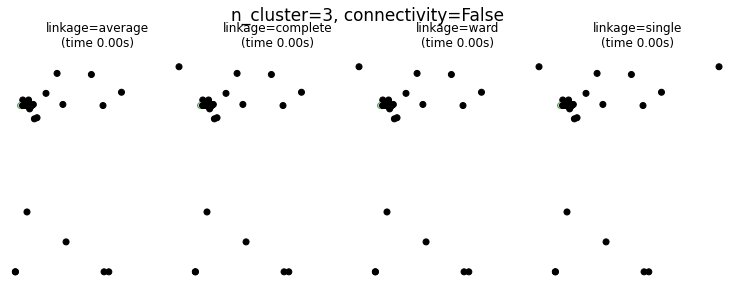

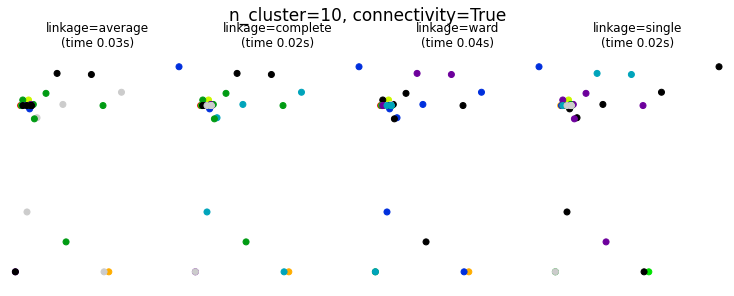

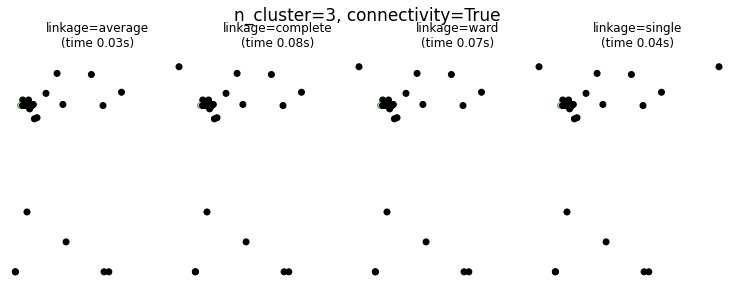

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
import time
from sklearn.neighbors import radius_neighbors_graph

rnn = RadiusNeighborsClassifier(radius=3.0)
rnn.fit(X_train, Y_train)
#RadiusNeighborsClassifier()
num_var = rnn.predict(X_test)
num_var
A = radius_neighbors_graph(X_train, 1.5, mode='connectivity', include_self=True)
for connectivity in (None, A):
    for n_clusters in (10, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
            )
            t0 = time.time()
            model.fit(X_train)
            elapsed_time = time.time() - t0
            plt.scatter(X_train.iloc[:, 2], X_train.iloc[:, -1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title(
                "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
                fontdict=dict(verticalalignment="top"),
            )
            plt.axis("equal")
            plt.axis("off")

            plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
            plt.suptitle(
                "n_cluster=%i, connectivity=%r"
                % (n_clusters, connectivity is not None),
                size=17,
            )

plt.savefig("Beta1.png")
plt.show()

In [ ]:
model_creation = Sequential([
                             Dense(4,input_dim=X_train.shape[1], activation='relu'),
                             Dense(1, activation='softmax')
])

In [ ]:
model_creation.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss= "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model_creation.fit(X_train,Y_train)

2/2 [==============================] - 3s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2558


In [ ]:
import numpy as np
yhat = model_creation.predict(X_test)
flathat = yhat.flatten()
tophat = flathat.argmax()
flathat[tophat]


0

In [ ]:
df.columns

Index(['Optimizer', 'Learning_Rate', 'Loss_Function', 'Size_of_Model',
       'Accuracy', 'Loss', 'Validation_Loss', 'Validation_Accuracy',
       'Model_name', 'ID_PROD'],
      dtype='object')

In [ ]:
df = df.drop(columns=["ID_PROD"])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

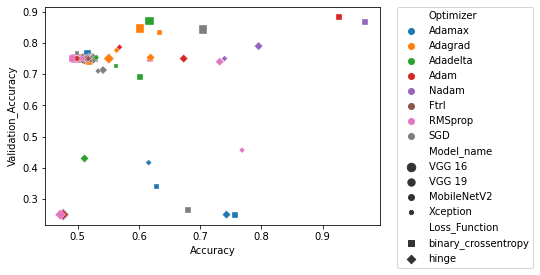

In [ ]:
scplot = sns.scatterplot(x= df['Accuracy'],y= df['Validation_Accuracy'],
                hue=df['Optimizer'], size=df['Model_name'],
                style=df['Loss_Function'], markers=["s", "D"],
                x_jitter=.5, y_jitter=.5,
                legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = scplot.get_figure()
fig.savefig("BetaTest1.png", bbox_inches="tight")
plt.show()

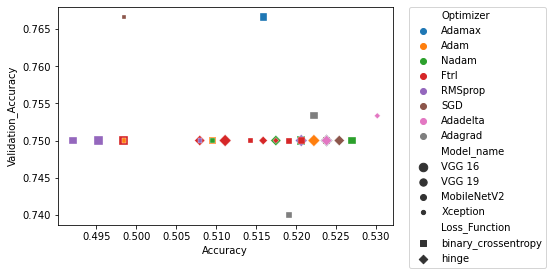

In [ ]:
df1 = df[(df['Accuracy'].between(.45,.55)) & (df['Validation_Accuracy'].between(.73,.8))]
scplot = sns.scatterplot(x= df1['Accuracy'],y= df1['Validation_Accuracy'],
                hue=df1['Optimizer'], size=df1['Model_name'],
                style=df1['Loss_Function'], markers=["s", "D"],
                x_jitter=.5, y_jitter=.5,
                legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = scplot.get_figure()
fig.savefig("BetaTest2.png", bbox_inches="tight")
plt.show()

In [ ]:
df1 = df['Validation_Accuracy']
df1 = pd.DataFrame(df1)

In [ ]:
df1['bins'] = pd.cut(df1['Validation_Accuracy'],bins=[0,.7,.8,1], labels=["Low","Average","High"])
df1 = df1.groupby(['bins']).size()

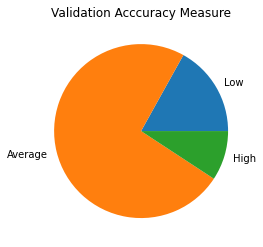

In [ ]:
ax = df1.plot.pie()
ax.set_title("Validation Acccuracy Measure")
ax.set_ylabel("")
plt.show()
fig = ax.get_figure()
fig.savefig("BetaTest3.png")